# XGBoost

In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

2022-11-09 22:32:59.063070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 22:32:59.216728: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-09 22:32:59.891610: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/compat/lib.real:/opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages/torch_tensorrt/lib:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64


['/device:CPU:0', '/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3', '/device:GPU:4', '/device:GPU:5', '/device:GPU:6', '/device:GPU:7']


2022-11-09 22:33:00.878014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 22:33:05.303859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 30934 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2022-11-09 22:33:05.305810: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:1 with 33066 MB memory:  -> device: 1, name: A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2022-11-09 22:33:05.307521: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:2 with 33066 MB memory:  -> device: 2, name: A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capab

In [3]:
import pandas as pd
import numpy as np
# import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier, plot_importance
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, mean_squared_error


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.filterwarnings('ignore')

In [4]:
%cd ..

/workspace/asurion_f22_jw


## Classification

In [5]:
df = pd.read_csv('fe_data/total_encoded_standardized_fillna.csv', index_col='id')

In [6]:
df.columns

Index(['quality_sale', 'accepted_flg', 'seven_day_churn', 'thirty_day_churn',
       'ninety_day_churn', 'exp', 'product_type_md', 'product_type_sd',
       'product_type_unknown', 'pmake_android',
       ...
       'perc_over65_normalized', 'perc_white_normalized',
       'perc_black_normalized', 'population_density_normalized',
       'latitude_normalized', 'longitude_normalized',
       'zipcode_accepted_prop_normalized',
       'zipcode_rejected_offers_normalized',
       'zipcode_accepted_offers_normalized',
       'zipcode_total_offers_normalized'],
      dtype='object', length=104)

In [7]:
data = df.drop(columns=['accepted_flg', 'seven_day_churn', 'thirty_day_churn', 'ninety_day_churn'])

In [8]:
import pickle
import time
class_column = 'quality_sale'
random_seed = 42

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=class_column), data[class_column],
                                                   test_size=0.3, random_state=random_seed, stratify=data[class_column])

start=time.time()
xgb_classifier = XGBClassifier()

tuning_grid = {'scale_pos_weight' : [(len(y_train)-y_train.sum())/y_train.sum()],
               'max_depth' : [8,9,10],
               'alpha' : [0.1, 0.3, 0.5],
#                'subsample': [0.25, 0.5, 0.75],
               'learning_rate': [0.05],
               'n_estimators': [50, 100, 200],
               'tree_method':['gpu_hist'],
               'eval_metric':['auc'],
                'objective' : ['binary:logistic']
                }

grid_search = GridSearchCV(xgb_classifier, param_grid = tuning_grid, cv = 5, return_train_score=True)
grid_search.fit(X_train, y_train)

print('best score for grid search:', grid_search.best_score_)

display(grid_search.best_params_)
print('Timer:', time.time()-start, 'seconds')
xgb_classifier = grid_search.best_estimator_
# preds = xgb_classifier.predict(X_test)
preds = xgb_classifier.predict_proba(X_test)
threshold=0.5
predictions = (preds[:,1] >= threshold).astype('int')

best score for grid search: 0.6867783116544905


{'alpha': 0.5,
 'eval_metric': 'auc',
 'learning_rate': 0.05,
 'max_depth': 10,
 'n_estimators': 200,
 'objective': 'binary:logistic',
 'scale_pos_weight': 10.215273737106585,
 'tree_method': 'gpu_hist'}

Timer: 3454.9227726459503 seconds


In [9]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.69      0.80    331064
           1       0.16      0.62      0.26     32408

    accuracy                           0.68    363472
   macro avg       0.55      0.65      0.53    363472
weighted avg       0.88      0.68      0.75    363472



In [10]:
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("xgboost_testset",'\n',
      "recall:",recall_score(y_test, predictions),'\n',
      "precision:",precision_score(y_test, predictions),'\n',
      "f1score:",f1_score(y_test, predictions),'\n',
      'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')
#       "confusion matrix:",confusion_matrix(y_test, predictions),'\n')

xgboost_testset 
 recall: 0.6174092816588497 
 precision: 0.16115366338866471 
 f1score: 0.2555933805542604 
 tn:226912, fp:104152, fn:12399, tp:20009 



In [11]:
#get vip info
vip = grid_search.best_estimator_.feature_importances_

#create df with vip info
feature_importances_info = pd.DataFrame({'feat_names':data.drop(columns=class_column).columns, 'vip': vip})

#get sign and magnitude information
feature_importances_info = feature_importances_info.assign(feature_importances_mag = abs(feature_importances_info['vip']),
                             feature_importances_sign = np.sign(feature_importances_info['vip']))
feature_importances_info = feature_importances_info.set_index('feat_names').sort_values(by='feature_importances_mag', ascending=False)
feature_importances_info

,vip,feature_importances_mag,feature_importances_sign
feat_names,,,
product_type_sd,0.13,0.13,1.00
zipcode_accepted_prop_normalized,0.08,0.08,1.00
technodoption_class_unknown,0.07,0.07,1.00
product_type_md,0.04,0.04,1.00
hh_education_4_high_school,0.02,0.02,1.00
zipcode_rejected_offers_normalized,0.02,0.02,1.00
lines_normalized,0.02,0.02,1.00
num_decline_normalized,0.02,0.02,1.00
time_of_day_23,0.02,0.02,1.00


In [12]:
# plot_importance(xgb_classifier)

In [13]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


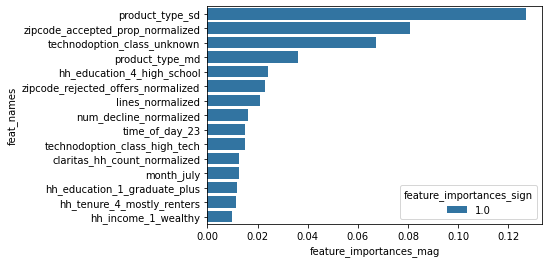

In [14]:
import seaborn as sns
sns.barplot(y=feature_importances_info.index[:15], x='feature_importances_mag', hue='feature_importances_sign', 
            data=feature_importances_info[:15], orient='h', dodge=False);